# Read me

A CTD is used to calibrate the Oxygen data from the glider. Oxygen is gridded along glider dives / climbs and pressure with a resolution of 1 db and set to the corresponding CTD oxygen units to compare the CTD with the nearest glider profile. The oxygen concentration between the glider and CTD can differ at locations where different water masses have been measured. Therefore the calibration is performed at a section where the oxygen concentration has a constant offset. 

# Packages

In [1]:
# Packages
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import ctd
import glob
import os
import matplotlib.pyplot as plt
import warnings
import csv
import sys
import array
import cmocean
import pathlib
from pathlib import Path
import netCDF4
from netCDF4 import Dataset as nc
import glidertools as gt
import gsw
from cmocean import cm as cmo
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
from scipy.interpolate import griddata

warnings.simplefilter("ignore", UserWarning)

# Function
def write_with_byte_inversion(f, tab):
    tab2write = array.array('f', tab.T.flatten())
    if sys.byteorder == 'little':
        tab2write.byteswap()
    f.write(tab2write)

dtype = np.float32


### load CTD data

In [2]:
ds_ctd = xr.open_mfdataset('C:/Users/rensk/OneDrive/Documenten/Physical Oceanography Master GU/mast thesis/Data/QUICCHE_CTDs.nc').load()

In [3]:
# Select the "up" cast from the oxygen_saturation_GG data
ox_upcast = ds_ctd.oxygen_concentration_mmm3.sel(cast='up')

# Select the "up" cast from the oxygen_saturation_GG data
ox_downcast = ds_ctd.oxygen_concentration_mmm3.sel(cast='down', station=15)


In [4]:
# Select temperature from down cast CTD
temperature = ds_ctd.temperature1.sel(cast='down', station=15)

In [5]:
# creating new dataset

# Extract the data from the DataArray objects
temp_data = temperature.values
ox_data = ox_downcast.values

# Get the dimension names for temp, salinity, and o2
temp_dims = temperature.dims
ox_dims = ox_downcast.dims

# Create the Dataset
ds_ctd = xr.Dataset(
    data_vars=dict(
        temp=(temp_dims, temp_data),
        ox_downcast = (ox_dims, ox_data),
        
    ),
    coords=dict(
        pressure = ds_ctd.pressure,
        latitude = ds_ctd.latitude,
        longitude = ds_ctd.longitude,
    ),
    attrs=dict(description="CTD dataset"),
)

# Print the dataset
print(ds_ctd)

<xarray.Dataset>
Dimensions:       (pressure: 5100, cast: 2, station: 25)
Coordinates:
  * pressure      (pressure) int64 0 1 2 3 4 5 ... 5094 5095 5096 5097 5098 5099
  * cast          (cast) object 'down' 'up'
  * station       (station) int64 1 2 3 4 5 6 7 8 9 ... 18 19 20 21 22 23 24 25
    longitude     (station, cast) float64 16.61 16.61 16.57 ... 17.67 17.67
    max_pressure  (cast, station) float64 3.685e+03 3.055e+03 ... 991.0
    latitude      (station, cast) float64 -35.02 -35.02 -35.34 ... -37.45 -37.45
Data variables:
    temp          (pressure) float64 nan nan nan nan 19.71 ... nan nan nan nan
    ox_downcast   (pressure) float64 nan nan nan nan 227.4 ... nan nan nan nan
Attributes:
    description:  CTD dataset


In [6]:
ds_ctd.to_netcdf('ds_ctd_down.nc')

## load cleaned glider data 

In [9]:
ds_work = xr.open_dataset('ds_clean1.nc')

ds_work

<xarray.Dataset>
Dimensions:        (sg_data_point: 1011760)
Coordinates:
    longitude      (sg_data_point) float64 ...
    latitude       (sg_data_point) float64 ...
    ctd_depth      (sg_data_point) float64 ...
    ctd_time_dt64  (sg_data_point) datetime64[ns] ...
    dives          (sg_data_point) float64 ...
    distance       (sg_data_point) float64 ...
    tot_distance   (sg_data_point) float64 ...
Dimensions without coordinates: sg_data_point
Data variables:
    temp           (sg_data_point) float64 ...
    salinity       (sg_data_point) float64 ...
    o2             (sg_data_point) float64 ...
    pressure       (sg_data_point) float64 ...
    optode_temp    (sg_data_point) float64 ...
Attributes:
    description:  dataset including gridded data and cleaned variables

In [10]:
density_comp = gsw.sigma0(ds_work.salinity, ds_work.temp)

In [11]:
# grid
depth = np.arange(-0.25, 1000.75, 0.5)
latitude = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.latitude, bins=depth)
longitude = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.longitude, bins= depth)
temp = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.temp, bins= depth)
sal = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.salinity, bins= depth)
o2 = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.o2, bins= depth)
p = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.pressure, bins = depth)
density = gt.grid_data(ds_work.dives, ds_work.ctd_depth, density_comp, bins = depth)
optodetemp = gt.grid_data(ds_work.dives, ds_work.ctd_depth, ds_work.optode_temp, bins=depth)

Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Mean bin size = 0.50
Mean depth binned (50 m) vertical sampling frequency = 0.53


C:\Users\rensk\anaconda3\Lib\site-packages\glidertools\helpers.py:42: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  arg_valu = str(locl[arg_name])


Calculate mean gps location per dive

In [12]:
# Calculate the mean longitude for each dive
mean_longitude_per_dive = longitude.mean(dim='ctd_depth')

# Print the mean longitude for each dive
#mean_longitude_per_dive

# Calculate the mean latititude for each dive
mean_latitude_per_dive = latitude.mean(dim='ctd_depth')

# Print the mean longitude for each dive
#mean_latitude_per_dive

Convert to similar units as CTD data

In [13]:
# Convert micromoles per kilogram (μmol/kg) to moles per kilogram (mmol/kg)
oxygen_mol_kg = ds_work.o2 / 1000

# density of water (in kg/m³)
water_density =  gsw.sigma0(ds_work.salinity, ds_work.temp) + 1000

# Convert moles per kilogram (mmol/kg) to millimoles per cubic meter (mmol/m³)
oxygen_mol_per_kg_to_mmol_per_m3 = oxygen_mol_kg * water_density 
oxygen_mol_per_kg_to_mmol_per_m3

<xarray.DataArray (sg_data_point: 1011760)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    longitude      (sg_data_point) float64 17.32 17.32 17.32 ... 16.82 16.82
    latitude       (sg_data_point) float64 -37.52 -37.52 ... -34.18 -34.18
    ctd_depth      (sg_data_point) float64 0.3871 0.8966 ... 0.01038 -0.1323
    ctd_time_dt64  (sg_data_point) datetime64[ns] 2023-03-22T08:33:43 ... 202...
    dives          (sg_data_point) float64 1.0 1.0 1.0 1.0 ... 297.5 297.5 297.5
    distance       (sg_data_point) float64 0.0 0.0005754 ... 0.001722 0.001542
    tot_distance   (sg_data_point) float64 0.0 0.0005754 ... 813.3 813.3
Dimensions without coordinates: sg_data_point

In [14]:
# creating new dataset with correct units

# Extract the data from the DataArray objects
temp_data = ds_work.temp.values
salinity_data = ds_work.salinity.values
o2_data = ds_work.o2.values
ctd_pressure_data= ds_work.pressure.values
optode_temp_data = ds_work.optode_temp.values
oxygen_s_data = oxygen_mol_per_kg_to_mmol_per_m3.values
#latitude_data = ds_work.latitude.values
#longitude_data = ds_work.longitude.values


# Get the dimension names for temp, salinity, and o2
temp_dims = ds_work.temp.dims
salinity_dims = ds_work.salinity.dims
o2_dims = ds_work.o2.dims
ctd_pressure_dims = ds_work.pressure.dims
optode_temp_dims = ds_work.optode_temp.dims
oxygen_s_dims = oxygen_mol_per_kg_to_mmol_per_m3.dims
#latitude_dims = ds_work.latitude_gsm.dims
#longitude_dims = ds_work.longitude_gsm.dims


# Create the Dataset
ds = xr.Dataset(
    data_vars=dict(
        temp=(temp_dims, temp_data),
        salinity=(salinity_dims, salinity_data),
        o2=(o2_dims, o2_data),
        pressure=(ctd_pressure_dims, ctd_pressure_data),
        optode_temp = (optode_temp_dims, optode_temp_data),
        oxygen_s = (oxygen_s_dims, oxygen_s_data)
        #latitude = (latitude_dims, latitude_data),
        #longitude  = (longitude_dims, longitude_data),
        
    ),
    coords=dict(
        dives=ds_work.dives,
        ctd_depth=ds_work.ctd_depth,
        #pressure = ds_work.pressure,
        longitude=ds_work.longitude,
        latitude=ds_work.latitude,
    ),
    attrs=dict(description="dataset including gridded data and cleaned variables"),
)

# Print the dataset
print(ds)

<xarray.Dataset>
Dimensions:        (sg_data_point: 1011760)
Coordinates:
    longitude      (sg_data_point) float64 17.32 17.32 17.32 ... 16.82 16.82
    latitude       (sg_data_point) float64 -37.52 -37.52 ... -34.18 -34.18
    ctd_depth      (sg_data_point) float64 0.3871 0.8966 ... 0.01038 -0.1323
    ctd_time_dt64  (sg_data_point) datetime64[ns] 2023-03-22T08:33:43 ... 202...
    distance       (sg_data_point) float64 0.0 0.0005754 ... 0.001722 0.001542
    tot_distance   (sg_data_point) float64 0.0 0.0005754 ... 813.3 813.3
    dives          (sg_data_point) float64 1.0 1.0 1.0 1.0 ... 297.5 297.5 297.5
Dimensions without coordinates: sg_data_point
Data variables:
    temp           (sg_data_point) float64 nan nan nan nan ... 18.3 nan nan nan
    salinity       (sg_data_point) float64 nan nan nan nan ... 35.6 nan nan nan
    o2             (sg_data_point) float64 nan nan nan nan ... nan nan nan nan
    pressure       (sg_data_point) float64 0.3903 0.9036 ... 0.01053 -0.1332
    o

# Load CTD dataset

In [15]:
#ox_upcast = xr.open_dataset('ox_upcast_data.nc')
ox_downcast = xr.open_dataset('ds_ctd_down.nc')

In [16]:
# Extract oxygen data at station 15
oxygendown_station_15 = ox_downcast.sel(station=15, cast= 'down')

Location of the CTD

In [17]:
# Extract longitude and latitude
down_longitude_station_15 = oxygendown_station_15.longitude.values
down_latitude_station_15 = oxygendown_station_15.latitude.values

print("Longitude downtake at Station 15:", down_longitude_station_15)
print("Latitude downtake at Station 15:", down_latitude_station_15)

Longitude downtake at Station 15: 17.354
Latitude downtake at Station 15: -37.5289


Get the Glider dive number that was closest to the CTD

In [18]:
# Assuming 'dataset' is your xarray.Dataset object
target_lat = down_latitude_station_15
target_lon = down_longitude_station_15

# Calculate the closeness metric
closeness = abs(ds.latitude - target_lat) + abs(ds.longitude - target_lon)

# Find the index where the closeness is minimized
closest_index = closeness.argmin().item()

# Extract the dive(s) value associated with this location
closest_dive = ds.dives.isel(sg_data_point=closest_index).item()

# Optionally, extract all data associated with this closest location
closest_data = ds.isel(sg_data_point=closest_index)

print(f"Closest dive: {closest_dive}")
print(closest_data)

Closest dive: 9.5
<xarray.Dataset>
Dimensions:        ()
Coordinates:
    longitude      float64 17.35
    latitude       float64 -37.53
    ctd_depth      float64 215.0
    ctd_time_dt64  datetime64[ns] 2023-03-23T09:31:03
    distance       float64 0.000702
    tot_distance   float64 18.79
    dives          float64 9.5
Data variables:
    temp           float64 8.271
    salinity       float64 34.81
    o2             float64 164.5
    pressure       float64 216.7
    optode_temp    float64 8.282
    oxygen_s       float64 168.9
Attributes:
    description:  dataset including gridded data and cleaned variables


# grid the cleaned Gliderdata 

In [19]:
x = ds.dives
y = ds.pressure
z = ds.oxygen_s

dives = np.arange(0, 296, 0.5)
pressure = np.arange(0, 1000, 1)
ox_glider = griddata((x, y), z, (dives[None,:], pressure[:,None]), method='linear')

Select data for the nearest dive with the CTD

In [20]:
# Find the indices where x_grid equals 9.5
indices = np.where(dives == 9.5)

# Select the corresponding values from z_grid
oxygen_glider = ox_glider[:, indices]

In [21]:
ox_ctd = oxygendown_station_15.ox_downcast[:1000]

CTD and glider data follows a trend between pressure 100 to 350 and 820 to 1000. Those are selected for calculating the offset. 

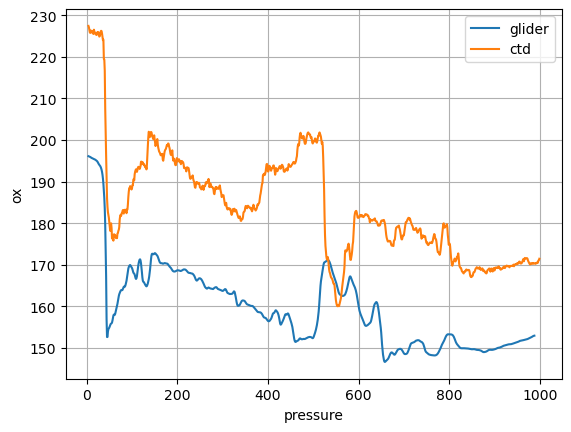

In [22]:
plt.plot(pressure, oxygen_glider[:,0,0], label= 'glider')
plt.plot(ox_ctd.pressure, ox_ctd, label= 'ctd')
plt.xlabel('pressure')
plt.ylabel('ox')
plt.grid()
plt.legend()

In [23]:
# Select values from ds2.oxygen_mol_per_kg_to_mmol_per_m3 within the specified range
selected_values_ds2 = oxygen_glider[(pressure >= 100) & (pressure <= 350) | (pressure >= 820) & (pressure <= 1000)] 

# Select values from sliced_data.ox_downcast within the specified range
selected_values_sliced_data = ox_ctd.where((ox_ctd['pressure'] >= 100) & (ox_ctd['pressure'] <= 350) | (ox_ctd['pressure'] >= 820) & (ox_ctd['pressure'] <= 1000), drop=True)

# Take the mean of the difference between the selected values
mean_difference = (selected_values_sliced_data- selected_values_ds2[:,0,0]).mean().item()

mean_difference



22.2842406288648

After calibration

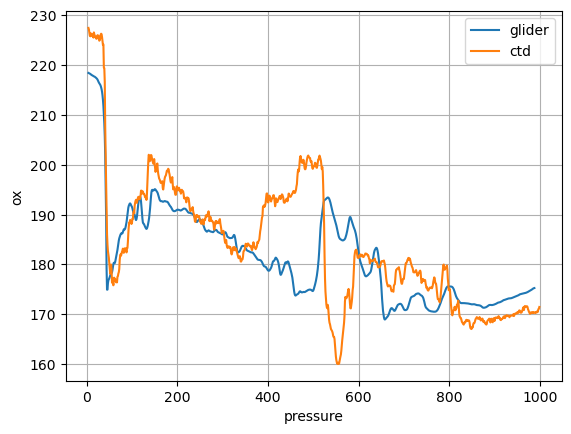

In [24]:
plt.plot(pressure, oxygen_glider[:,0,0]+mean_difference, label= 'glider')
plt.plot(ox_ctd.pressure, ox_ctd, label= 'ctd')
plt.xlabel('pressure')
plt.ylabel('ox')
plt.grid()
plt.legend()

In [25]:
# bias

bias = (ox_ctd- ( oxygen_glider[:,0,0]+mean_difference)).mean()
bias

<xarray.DataArray 'ox_downcast' ()>
array(2.22532095)
Coordinates:
    cast          <U4 'down'
    station       int64 15
    longitude     float64 17.35
    max_pressure  float64 ...
    latitude      float64 -37.53

In [26]:
offset_micro_p_kg = (mean_difference/ water_density)*1000

oxygen_calibrated = offset_micro_p_kg + ds_work.o2


# Save the calibrated oxygen dataset

In [27]:
# creating new dataset

# Extract the data from the DataArray objects
temp_data = ds_work.temp.values
salinity_data = ds_work.salinity.values
o2_data = oxygen_calibrated.values
ctd_pressure_data= ds_work.pressure.values



# Get the dimension names for temp, salinity, and o2
temp_dims = ds_work.temp.dims
salinity_dims = ds_work.salinity.dims
o2_dims = oxygen_calibrated.dims
ctd_pressure_dims = ds_work.pressure.dims


# Create the Dataset
ds = xr.Dataset(
    data_vars=dict(
        temp=(temp_dims, temp_data),
        salinity=(salinity_dims, salinity_data),
        o2=(o2_dims, o2_data),
        pressure=(ctd_pressure_dims, ctd_pressure_data),

        
    ),
    coords=dict(
        dives=ds_work.dives,
        ctd_depth=ds_work.ctd_depth,
        #pressure = ds_work.pressure,
        longitude=ds_work.longitude,
        latitude=ds_work.latitude,
        distance=ds_work.distance,
    ),
    attrs=dict(description="dataset including QC and calibrated variables"),
)

# Print the dataset
print(ds)

<xarray.Dataset>
Dimensions:        (sg_data_point: 1011760)
Coordinates:
    longitude      (sg_data_point) float64 17.32 17.32 17.32 ... 16.82 16.82
    latitude       (sg_data_point) float64 -37.52 -37.52 ... -34.18 -34.18
    ctd_depth      (sg_data_point) float64 0.3871 0.8966 ... 0.01038 -0.1323
    ctd_time_dt64  (sg_data_point) datetime64[ns] 2023-03-22T08:33:43 ... 202...
    distance       (sg_data_point) float64 0.0 0.0005754 ... 0.001722 0.001542
    tot_distance   (sg_data_point) float64 0.0 0.0005754 ... 813.3 813.3
    dives          (sg_data_point) float64 1.0 1.0 1.0 1.0 ... 297.5 297.5 297.5
Dimensions without coordinates: sg_data_point
Data variables:
    temp           (sg_data_point) float64 nan nan nan nan ... 18.3 nan nan nan
    salinity       (sg_data_point) float64 nan nan nan nan ... 35.6 nan nan nan
    o2             (sg_data_point) float64 nan nan nan nan ... nan nan nan nan
    pressure       (sg_data_point) float64 0.3903 0.9036 ... 0.01053 -0.1332
Attri

In [28]:
ds.to_netcdf('ds_cal.nc')

In [6]:
ds_ctd.to_netcdf('ds_ctd')

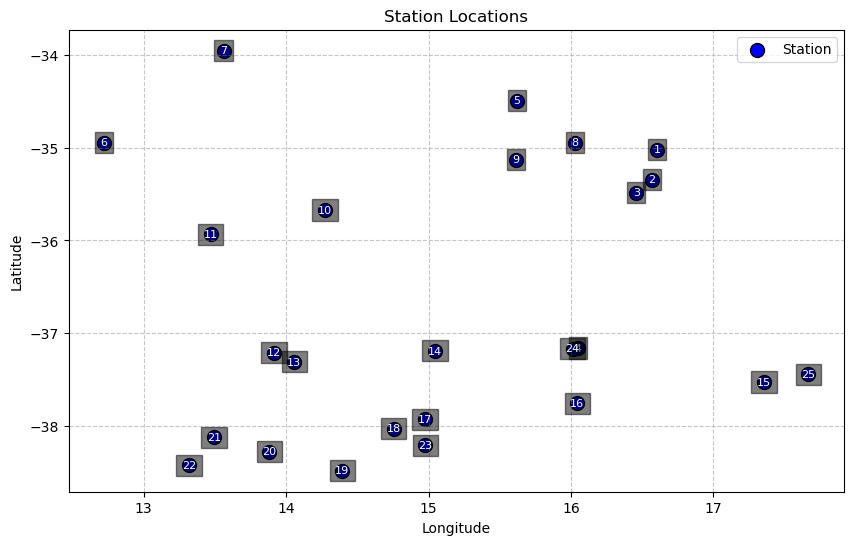

In [5]:
import matplotlib.pyplot as plt

# Extract latitude and longitude for "down" cast
# Assuming 'cast' dimension has values 'down' and 'up'
lat_down = ds_ctd.latitude.sel(cast='down')
lon_down = ds_ctd.longitude.sel(cast='down')

# Extract station numbers
stations = ds_ctd.station.values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(lon_down, lat_down, c='blue', edgecolor='black', s=100, label='Station')

# Annotate each station number
for i, station in enumerate(stations):
    plt.text(lon_down[i], lat_down[i], str(station), fontsize=8, ha='center', va='center', color='white', bbox=dict(facecolor='black', alpha=0.5))

# Customize the plot
plt.title('Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()
